In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv('data/df_cleaned.csv')

C:\Users\carlo\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (99) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## penultima limpieza

In [3]:
df['gk'] =df['gk'].replace("+","")

In [4]:
df['gk'] = df['gk'].str.replace(r'\+', '', regex=True)


In [5]:
df.gk.fillna(0,inplace=True)

In [6]:
df['gk']=df.gk.astype(int)

In [7]:
df['gk'].unique()

array([15, 16, 14, 17, 87, 34, 13, 18, 85, 83,  8, 84, 12, 82,  9, 11, 80,
       81, 20,  6,  7, 79, 35, 10, 78, 77,  5, 76, 75, 25, 74, 73, 72, 27,
       33, 71, 70, 69, 68, 67, 66, 65, 39, 64, 63, 62, 61, 60, 59,  4, 58,
       57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 43, 19, 37, 21, 38,
       23, 22, 29, 31, 28, 32, 44, 89, 86, 45, 90, 88, 24,  0])

## Añadir variable años pendientes de contrato

In [8]:
df['años_de_contrato']=np.where((df['club_contract_valid_until']-df['año_version'])<0,0,(df['club_contract_valid_until']-df['año_version']))

In [9]:
#comprobación
df.groupby('años_de_contrato')['años_de_contrato'].count()

años_de_contrato
0.0    30707
1.0    21182
2.0    17779
3.0     9287
4.0     4872
5.0     2502
6.0     1413
7.0        3
8.0        2
Name: años_de_contrato, dtype: int64

## Agrupar columna bodytype

In [10]:
Lean=['Lean (170-)','Lean (185+)','Lean (170-185)']
Normal=['Normal (170-)','Normal (170-185)','Normal (185+)']
Stocky=['Stocky (170-)','Stocky (170-185)','Stocky (185+)']

In [11]:
#agrupo posiciones en posiciones genéricas    
for i in df.index:
    if df.at[i,'body_type'] in Lean:
        df.at[i,'body_type']='Lean'
    elif df.at[i,'body_type'] in Normal:
        df.at[i,'body_type']='Normal'
    elif df.at[i,'body_type'] in Stocky:
        df.at[i,'body_type']='Stocky'
    else:
        pass

## feature engineering

In [12]:
df.preferred_foot.value_counts() #categorica a OHE

Right    66970
Left     20777
Name: preferred_foot, dtype: int64

In [13]:
df.work_rate.value_counts() #categorica transformarla con un ordinal encoder

Medium/Medium    47248
High/Medium      15911
Medium/High       8196
High/High         4712
Medium/Low        4072
High/Low          3332
Low/Medium        2078
Low/High          2058
Low/Low            140
Name: work_rate, dtype: int64

In [14]:
df.body_type.value_counts() #Transformar la variable de más a menos mosculado con un ordinal encoder
#(Lean < Normal < Stocky) + Unique = -1
#oe_cat = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, categories=[unique_categories for _ in ["columns", "you", "want"]])

Normal    51581
Lean      30898
Stocky     5099
Unique      169
Name: body_type, dtype: int64

In [15]:
df.real_face.value_counts() #categorica a OHE

No     78885
Yes     8862
Name: real_face, dtype: int64

In [16]:
df.año_version.value_counts() #categorica a OHE

2021    13300
2020    13275
2019    13194
2018    12689
2017    12607
2016    11442
2015    11240
Name: año_version, dtype: int64

In [17]:
df.player_positions.value_counts() #categorica a OHE

centrocampista    36424
defensa           29039
delantero         12650
portero            9634
Name: player_positions, dtype: int64

In [18]:
#ver todas las variables 
pd.set_option('display.max_columns', None)
print(df.columns.tolist())

['sofifa_id', 'short_name', 'long_name', 'player_positions', 'overall', 'potential', 'value_eur', 'wage_eur', 'age', 'dob', 'height_cm', 'weight_kg', 'club_team_id', 'club_name', 'league_name', 'league_level', 'club_position', 'club_jersey_number', 'club_joined', 'club_contract_valid_until', 'nationality_id', 'nationality_name', 'nation_team_id', 'nation_position', 'preferred_foot', 'weak_foot', 'skill_moves', 'international_reputation', 'work_rate', 'body_type', 'real_face', 'player_traits', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 'mentalit

In [19]:
#eliminamos columnas que sabemos seguro que sólo aportan ruido
df.drop(["sofifa_id",'short_name', 'long_name',"nationality_id","dob",'club_team_id', 'club_name', 'league_name',
        'club_jersey_number', 'club_joined', 'club_contract_valid_until','nationality_id', 'nationality_name','player_traits',
        'ranking','puntos'],axis=1,inplace=True)

## Filtramos el dataset por posicion

In [ ]:
#Viendo el tipo de coliniaridad se ve necesario probar a separar el dataset en 4 por posicion

In [20]:
df=df[df['player_positions']=='centrocampista']


## Feacture selection

In [22]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

In [24]:
work_rate_ord=['Low/Low','Low/Medium','Low/High','Medium/Low','Medium/Medium','Medium/High','High/Low','High/Medium','High/High']
league_level_ord=['0.0','4.0','3.0','2.0','1.0']
#body_type_ord=['Lean','Normal','Stocky'] con OHE

In [25]:
df['league_level']=df['league_level'].apply(str)

In [26]:
df.drop('player_positions',axis=1,inplace=True)

In [27]:
categorical = df.dtypes == object
categorical[categorical==True]

league_level      True
preferred_foot    True
work_rate         True
body_type         True
real_face         True
dtype: bool

In [28]:
#definimos X e y
X=df.drop('progresion_anual',axis=1)
y=df['progresion_anual']

In [29]:

feature_engineering=make_column_transformer((OrdinalEncoder(categories=[work_rate_ord,league_level_ord]),['work_rate','league_level']),
                                            (OneHotEncoder(drop='first'),['preferred_foot','body_type','real_face','año_version','nation_team_id','club_position']),
                                            (StandardScaler(),  X.select_dtypes('number').drop(['año_version','club_position','nation_team_id'],axis=1).columns) 
                                           )

In [30]:
#transformamos las X en variables numéricas todas
X_features = feature_engineering.fit_transform(X)

In [31]:
#comprobamos tamaño
X_features.shape

(36424, 99)

In [32]:
from sklearn.feature_selection import SelectFromModel, SelectKBest, mutual_info_regression
from sklearn.pipeline import Pipeline

In [33]:
#formula para sacar los nombres de un X_features
def get_column_names_from_ColumnTransformer(column_transformer):    
    col_name = []
    for transformer_in_columns in column_transformer.transformers_[:-1]:#the last transformer is ColumnTransformer's 'remainder'
        raw_col_name = transformer_in_columns[2]
        if isinstance(transformer_in_columns[1],Pipeline): 
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
        try:
            names = transformer.get_feature_names()
        except AttributeError: # if no 'get_feature_names' function, use raw column name
            names = raw_col_name
        if isinstance(names,np.ndarray): # eg.
            col_name += names.tolist()
        elif isinstance(names,list):
            col_name += names    
        elif isinstance(names,str):
            col_name.append(names)
    return col_name

In [34]:
m=mutual_info_regression(X_features, y)

In [35]:
#obtengo todos los nombres en una lista
variables=(get_column_names_from_ColumnTransformer(feature_engineering))+X.select_dtypes('number').drop(['año_version','club_position','nation_team_id'],axis=1).columns.to_list()

C:\Users\carlo\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [36]:
pd.Series(m,index=variables).sort_values(kind="quicksort",ascending=False).head(20)

overall               2.516563
value_eur             0.964549
rm                    0.902283
lm                    0.899615
cam                   0.854957
ram                   0.852466
lam                   0.849245
rf                    0.748304
lf                    0.748006
cf                    0.747299
rw                    0.734355
lw                    0.731646
cm                    0.726283
rcm                   0.726240
lcm                   0.724937
skill_ball_control    0.578109
potential             0.553706
ls                    0.524088
wage_eur              0.521036
rs                    0.520878
dtype: float64

In [37]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet

In [38]:
LinearRegression().fit(X_features, y).score(X_features, y)

0.3010051916663351

## Examinar correlaciones entre variables

In [42]:
c = df.select_dtypes('number').drop(['año_version','club_position','nation_team_id'],axis=1).corr().abs()

s = c.unstack()
so = s[s<1].sort_values(kind="quicksort")
#so.shape
print(so[so>0.90])

physic          power_strength    0.900940
power_strength  physic            0.900940
passing         cam               0.902006
lam             passing           0.902006
ram             passing           0.902006
                                    ...   
rm              rw                0.985076
lm              rw                0.985076
                lw                0.985076
lw              rm                0.985076
                lm                0.985076
Length: 360, dtype: float64


In [43]:
df_corr=so.to_frame(name='correlacion')

In [44]:
df_corr=df_corr[df_corr['correlacion']>0.90].reset_index().rename(columns={'level_0':'variable_1','level_1':'variable_2'})

In [45]:
df_corr #Hay una alta coliniaridad entre 360 combinaciones de variables

,variable_1,variable_2,correlacion
0,physic,power_strength,0.900940
1,power_strength,physic,0.900940
2,passing,cam,0.902006
3,lam,passing,0.902006
4,ram,passing,0.902006
...,...,...,...
355,rm,rw,0.985076
356,lm,rw,0.985076
357,lm,lw,0.985076
358,lw,rm,0.985076


<AxesSubplot:>

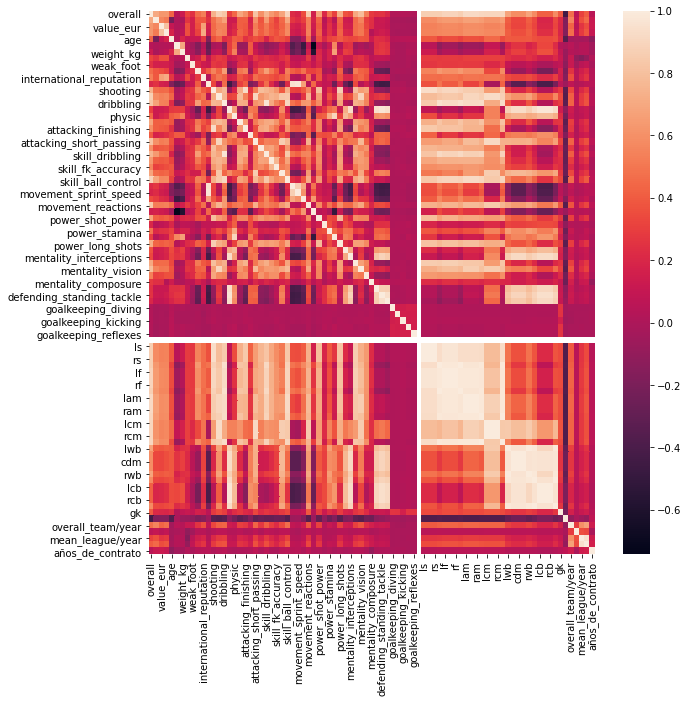

In [39]:
plt.rcParams['figure.figsize'] = (10,10)
sns.heatmap(df.select_dtypes('number').drop(['año_version','club_position','nation_team_id'],axis=1).corr())


## Eliminar coliniaridad con VIF

In [40]:
data_num=df.select_dtypes('number').drop(['año_version','club_position','nation_team_id'],axis=1)

In [41]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

In [73]:
%%time
X = sm.add_constant(data_num.drop(['progresion_anual','lw','lm','rm','cf','lf','lcm','cam','ls','rdm','st','rcm','cm','lam',
                                  'rcb','lcb','lb','rwb','rf','rdm','cdm','physic','pace','cb','shooting','passing',
                                  'dribbling','ldm','lwb','ram','rw','defending_standing_tackle','defending_marking_awareness',
                                  'rs','mentality_interceptions','rb','mean_team/year','defending','skill_ball_control',
                                  'attacking_short_passing','skill_dribbling','movement_acceleration','movement_sprint_speed',
                                  'potential','movement_reactions','goalkeeping_speed','goalkeeping_kicking',
                                  'goalkeeping_kicking','goalkeeping_diving','goalkeeping_handling','goalkeeping_positioning', 'goalkeeping_reflexes', 'gk',
                                  ],axis=1))
VIF=pd.Series([variance_inflation_factor(X,i) for i in range (1, X.shape[1])],index=X.columns[1:]).sort_values(kind="quicksort",ascending=False)
VIF[1:].head()

Wall time: 2.78 s


wage_eur            4.174984
power_long_shots    4.054397
mentality_vision    3.908176
value_eur           3.793606
skill_curve         3.689649
dtype: float64

In [74]:
VIF[1:].tail()

nation_position         1.352582
mentality_composure     1.309479
teams_in_league/year    1.200207
weak_foot               1.114261
años_de_contrato        1.083349
dtype: float64

In [75]:
df_sin_coliniaridad=data_num.drop(['progresion_anual','lw','lm','rm','cf','lf','lcm','cam','ls','rdm','st','rcm','cm','lam',
                                  'rcb','lcb','lb','rwb','rf','rdm','cdm','physic','pace','cb','shooting','passing',
                                  'dribbling','ldm','lwb','ram','rw','defending_standing_tackle','defending_marking_awareness',
                                  'rs','mentality_interceptions','rb','mean_team/year','defending','skill_ball_control',
                                  'attacking_short_passing','skill_dribbling','movement_acceleration','movement_sprint_speed',
                                  'potential','movement_reactions','goalkeeping_speed','goalkeeping_kicking',
                                  'goalkeeping_kicking','goalkeeping_diving','goalkeeping_handling','goalkeeping_positioning', 'goalkeeping_reflexes', 'gk',
                                  ],axis=1)

<AxesSubplot:>

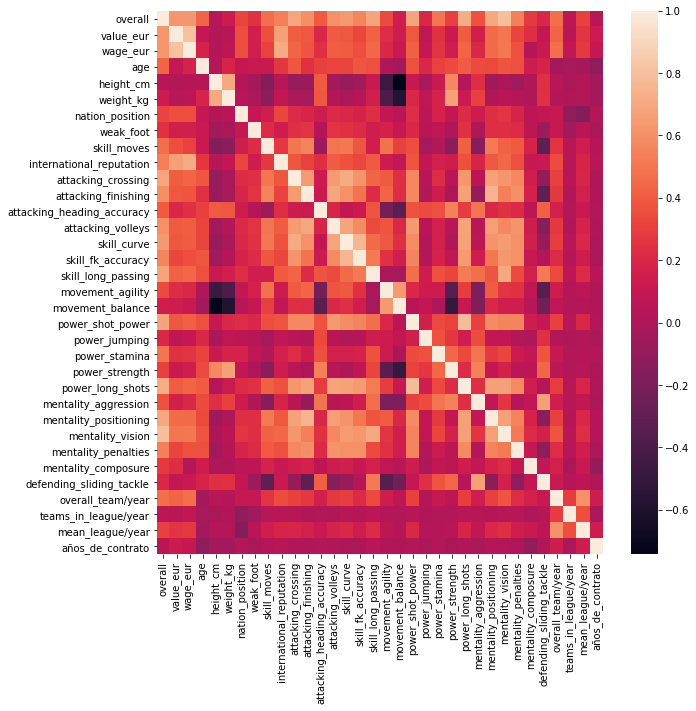

In [76]:
plt.rcParams['figure.figsize'] = (10,10)
sns.heatmap(df_sin_coliniaridad.corr())

In [77]:
df_sin_coliniaridad.columns

Index(['overall', 'value_eur', 'wage_eur', 'age', 'height_cm', 'weight_kg',
       'nation_position', 'weak_foot', 'skill_moves',
       'international_reputation', 'attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_volleys', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'movement_agility',
       'movement_balance', 'power_shot_power', 'power_jumping',
       'power_stamina', 'power_strength', 'power_long_shots',
       'mentality_aggression', 'mentality_positioning', 'mentality_vision',
       'mentality_penalties', 'mentality_composure',
       'defending_sliding_tackle', 'overall_team/year', 'teams_in_league/year',
       'mean_league/year', 'años_de_contrato'],
      dtype='object')

## Creación de pipeline

In [103]:
#definimos X e y
X=df_sin_coliniaridad.join(df.select_dtypes(include='object')).join(df[['año_version','club_position','nation_team_id']])
y=df['progresion_anual']

In [104]:
X.columns

Index(['overall', 'value_eur', 'wage_eur', 'age', 'height_cm', 'weight_kg',
       'nation_position', 'weak_foot', 'skill_moves',
       'international_reputation', 'attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_volleys', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'movement_agility',
       'movement_balance', 'power_shot_power', 'power_jumping',
       'power_stamina', 'power_strength', 'power_long_shots',
       'mentality_aggression', 'mentality_positioning', 'mentality_vision',
       'mentality_penalties', 'mentality_composure',
       'defending_sliding_tackle', 'overall_team/year', 'teams_in_league/year',
       'mean_league/year', 'años_de_contrato', 'league_level',
       'preferred_foot', 'work_rate', 'body_type', 'real_face', 'año_version',
       'club_position', 'nation_team_id'],
      dtype='object')

In [111]:
feature_engineering=make_column_transformer((OrdinalEncoder(categories=[work_rate_ord,league_level_ord]),['work_rate','league_level']),
                                            (OneHotEncoder(drop='first'),['preferred_foot','body_type','real_face','año_version','nation_team_id','club_position']),
                                            (StandardScaler(),  X.select_dtypes('number').drop(['año_version','club_position','nation_team_id','nation_position'],axis=1).columns)
                                           )

In [112]:
#creamos un pipeline?
pipe = make_pipeline(feature_engineering, Ridge())

In [113]:
pipe.fit(X,y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Low/Low',
                                                                              'Low/Medium',
                                                                              'Low/High',
                                                                              'Medium/Low',
                                                                              'Medium/Medium',
                                                                              'Medium/High',
                                                                              'High/Low',
                                                                              'High/Medium',
                                                                              'High/High'],
                                                                    

In [114]:
pipe.score(X,y)

0.29268615253295716

In [115]:
from sklearn.model_selection import GridSearchCV

In [116]:
params={'ridge__alpha':10.0**np.arange(-3,3)}

In [117]:
model=GridSearchCV(pipe, param_grid=params, cv=5) .fit(X,y)

C:\Users\carlo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

C:\Users\carlo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

C:\Users\carlo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

C:\Users\carlo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

C:\Users\carlo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

C:\Users\carlo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\pipeline.py", line 707, in score
    Xt = transform.transform(Xt)
  File "C:\Users\carlo\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py", line 748, in transform
    Xs = self._fit_trans

In [118]:
model.best_params_

{'ridge__alpha': 0.001}

In [119]:
model.best_estimator_.fit(X,y).score(X,y)

0.2926867174351133

In [ ]:
#Aquí hay que hacer la curva ROC para decididir el umbral
#from sklearn.metrics import auc, roc_curve
#fpr, tpr, th=roc_curve(y, p[:,1])

## Modelos clasificación

In [120]:
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn import ensemble



In [125]:
from sklearn.metrics import classification_report
target=[]
#elegimos el % de target para que sea 0 y 1
for i in df.progresion_anual:
    if i>0.1:
        target.append(1)
    else:
        target.append(0)
df["target"]=target


In [75]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']


In [124]:
X_features = feature_engineering.fit_transform(X)

In [126]:
#elegir la X
X=X_features
y=df.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state=42)

In [149]:
#rebalanceo
import imblearn
from imblearn.under_sampling import RandomUnderSampler
X_res, y_res = RandomUnderSampler().fit_resample(X,y)

In [151]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.15, random_state=42)

In [152]:
#modelo1
model1=ensemble.RandomForestRegressor().fit(X_train,y_train)

In [153]:
model1.score(X_test,y_test)

0.4153606302079118

In [154]:
#modelo2
model2=DecisionTreeRegressor().fit(X_train,y_train)
y_pred=model2.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.67      0.70       282
           1       0.68      0.74      0.71       263

    accuracy                           0.71       545
   macro avg       0.71      0.71      0.71       545
weighted avg       0.71      0.71      0.71       545



In [155]:
#modelo3
model3=DecisionTreeClassifier().fit(X_train,y_train)
y_pred=model3.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.66      0.69       282
           1       0.67      0.74      0.70       263

    accuracy                           0.70       545
   macro avg       0.70      0.70      0.70       545
weighted avg       0.70      0.70      0.70       545



In [143]:
model3.get_depth()

28

In [158]:
#modelo4
model4=svm.SVC()
model4.fit(X_train,y_train).score(X_test,y_test)
y_pred=model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.72      0.78       282
           1       0.74      0.87      0.80       263

    accuracy                           0.79       545
   macro avg       0.80      0.79      0.79       545
weighted avg       0.80      0.79      0.79       545



In [159]:
model4.score(X_test,y_test)

0.7908256880733945

In [160]:
help(model4)

Help on SVC in module sklearn.svm._classes object:

class SVC(sklearn.svm._base.BaseSVC)
 |  SVC(*, C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=None)
 |  
 |  C-Support Vector Classification.
 |  
 |  The implementation is based on libsvm. The fit time scales at least
 |  quadratically with the number of samples and may be impractical
 |  beyond tens of thousands of samples. For large datasets
 |  consider using :class:`~sklearn.svm.LinearSVC` or
 |  :class:`~sklearn.linear_model.SGDClassifier` instead, possibly after a
 |  :class:`~sklearn.kernel_approximation.Nystroem` transformer.
 |  
 |  The multiclass support is handled according to a one-vs-one scheme.
 |  
 |  For details on the precise mathematical formulation of the provided
 |  kernel functions and how `gamma`, `coef0` and `degree` affect each


## Hiperparametric tunnig

In [161]:
from sklearn.model_selection import GridSearchCV

In [162]:
params = {'C': 10.0 ** np.arange(-2,3),
         'kernel':['linear','rbf'],
         'gamma':['scale','auto']}

In [164]:
model=GridSearchCV(svm.SVC(), param_grid=params, cv=5)

In [165]:
model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']})

In [170]:
model.best_params_

{'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}

In [167]:
y_pred=model.best_estimator_.predict(X_test)

In [168]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.72      0.78       282
           1       0.74      0.87      0.80       263

    accuracy                           0.79       545
   macro avg       0.80      0.79      0.79       545
weighted avg       0.80      0.79      0.79       545



In [171]:
model.score(X_test,y_test) #no cambia respecto a los parámetros por defecto

0.7908256880733945